# From Neurons to Networks: Exploring Deep Learning Algorithms

Roderick Perez, Ph.D.
OMV

---

In [23]:
# Required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import time
import itertools
import random

1. Download the Solar Sunspot Dataset

In [2]:
# Download dataset (monthly sunspot data)
filePath = 'sunspot_data.csv'
data = pd.read_csv(filePath)

In [3]:
# Display the first few rows
data.head()

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,0,1818,1,1,1818.001,-1,-1.0,0,1
1,1,1818,1,2,1818.004,-1,-1.0,0,1
2,2,1818,1,3,1818.007,-1,-1.0,0,1
3,3,1818,1,4,1818.010,-1,-1.0,0,1
4,4,1818,1,5,1818.012,-1,-1.0,0,1


In [4]:
# Filter out rows with invalid sunspot data (e.g., where "Number of Sunspots" is -1)
filtered_data = data[data['Number of Sunspots'] >= 0]

# Use only the "Number of Sunspots" column for the RNN
sunspots = filtered_data['Number of Sunspots'].values

# Display first few rows to check the data
filtered_data.head()

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
7,7,1818,1,8,1818.021,65,10.2,1,1
12,12,1818,1,13,1818.034,37,7.7,1,1
16,16,1818,1,17,1818.045,77,11.1,1,1
17,17,1818,1,18,1818.048,98,12.6,1,1
18,18,1818,1,19,1818.051,105,13.0,1,1


In [5]:
print(f"Filtered data shape: {filtered_data.shape}")
print(f"Sunspots shape: {sunspots.shape}")

Filtered data shape: (70471, 9)
Sunspots shape: (70471,)


2. Plot the Dataset Using Matplotlib

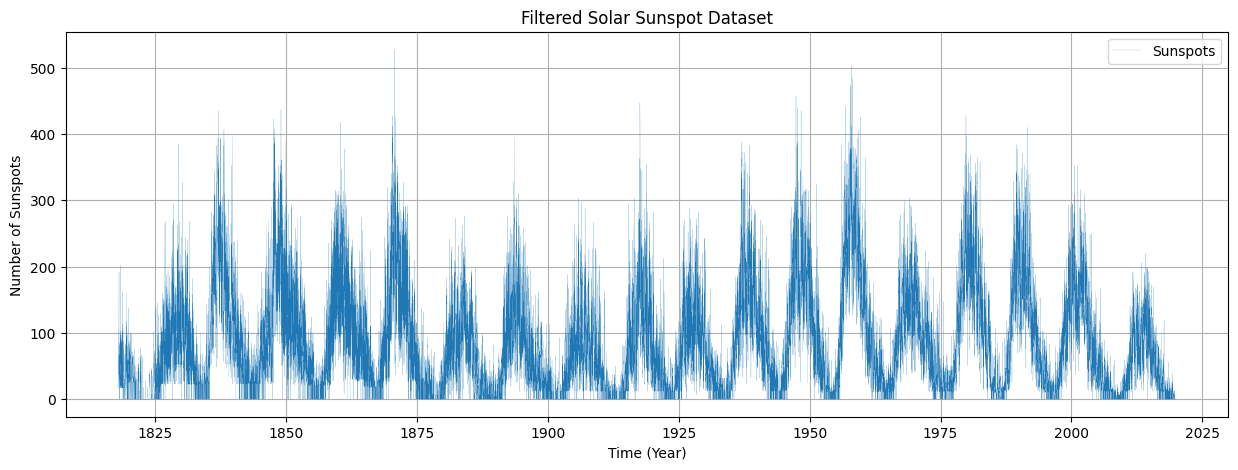

In [6]:
# Plot the dataset
plt.figure(figsize=(15, 5))
plt.plot(filtered_data['Date In Fraction Of Year'], sunspots, label='Sunspots', linewidth = 0.1)
plt.title('Filtered Solar Sunspot Dataset')
plt.xlabel('Time (Year)')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.grid(True)
plt.show()

---

Select only 20% of the dataset

# Set data percentage for training (5%)

In [7]:
data_percentage = 0.05  # Can be adjusted later
data_len = int(len(sunspots) * data_percentage)
sunspots = sunspots[:data_len]

In [8]:
# Display filtered data shape
print(f"Filtered data shape: {filtered_data.shape}")
print(f"Sunspots shape: {sunspots.shape}")

Filtered data shape: (70471, 9)
Sunspots shape: (3523,)


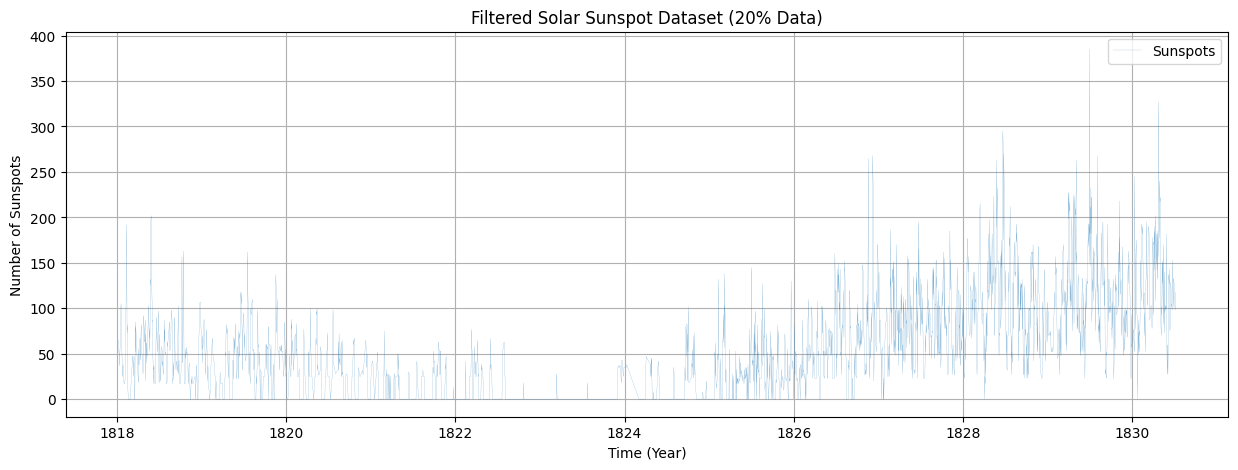

In [9]:
# Step 2: Plot the Dataset Using Matplotlib
plt.figure(figsize=(15, 5))
plt.plot(filtered_data['Date In Fraction Of Year'][:data_len], sunspots, label='Sunspots', linewidth=0.1)
plt.title('Filtered Solar Sunspot Dataset (20% Data)')
plt.xlabel('Time (Year)')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Create windowed dataset
def create_windowed_dataset(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [11]:
# Set window size (e.g., 12 months or timesteps)
window_size = 12
X, y = create_windowed_dataset(sunspots, window_size)

In [12]:
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

In [13]:
# Modify the LSTM class
class SunspotLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(SunspotLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [14]:
# Training function
def train_model(learning_rate, hidden_layer_size, epochs=50):
    model = SunspotLSTM(input_size=1, hidden_layer_size=hidden_layer_size, output_size=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()
    losses = []

    start_time = time.time()

    for epoch in range(epochs):
        total_loss = 0
        for seq, label in zip(X, y):
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)
            label = label.view_as(y_pred)
            loss = loss_function(y_pred, label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        avg_loss = total_loss / len(X)
        losses.append(avg_loss)

    execution_time = time.time() - start_time
    return losses, execution_time

In [15]:
# Hyperparameter tuning using grid search
def grid_search(lr_list, hidden_size_list, epochs=50):
    results = []
    for lr, hidden_size in itertools.product(lr_list, hidden_size_list):
        losses, exec_time = train_model(lr, hidden_size, epochs)
        results.append({
            'learning_rate': lr,
            'hidden_layer_size': hidden_size,
            'losses': losses,
            'execution_time': exec_time
        })
    return results

In [16]:
# Hyperparameter tuning using random search
def random_search(lr_range, hidden_size_range, n_iter=10, epochs=50):
    results = []
    for _ in range(n_iter):
        lr = random.uniform(*lr_range)
        hidden_size = random.randint(*hidden_size_range)
        losses, exec_time = train_model(lr, hidden_size, epochs)
        results.append({
            'learning_rate': lr,
            'hidden_layer_size': hidden_size,
            'losses': losses,
            'execution_time': exec_time
        })
    return results

In [17]:
# Hyperparameter ranges
lr_list = [0.0001, 0.001, 0.01]
hidden_size_list = [10, 50, 100]

In [18]:
# Perform grid search
grid_results = grid_search(lr_list, hidden_size_list)

In [19]:
# Perform random search
lr_range = (0.0001, 0.01)
hidden_size_range = (10, 100)
random_results = random_search(lr_range, hidden_size_range)

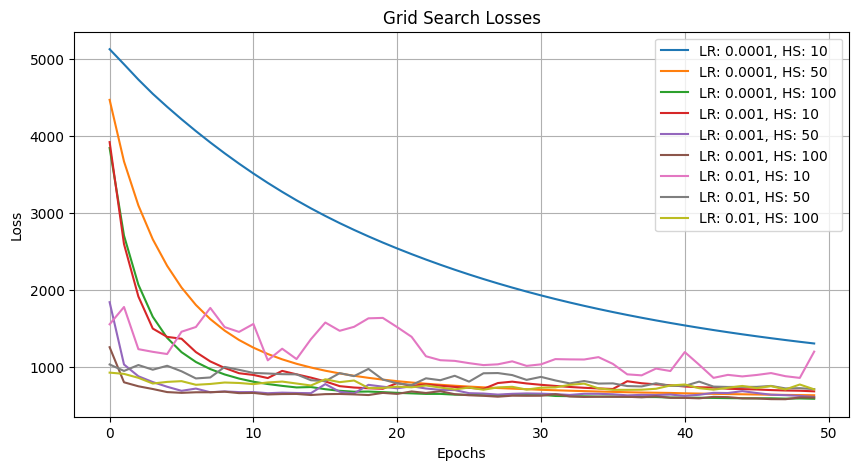

In [20]:
# Plot results for grid search
plt.figure(figsize=(10, 5))
for result in grid_results:
    plt.plot(result['losses'], label=f"LR: {result['learning_rate']}, HS: {result['hidden_layer_size']}")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Grid Search Losses')
plt.legend()
plt.grid(True)
plt.show()

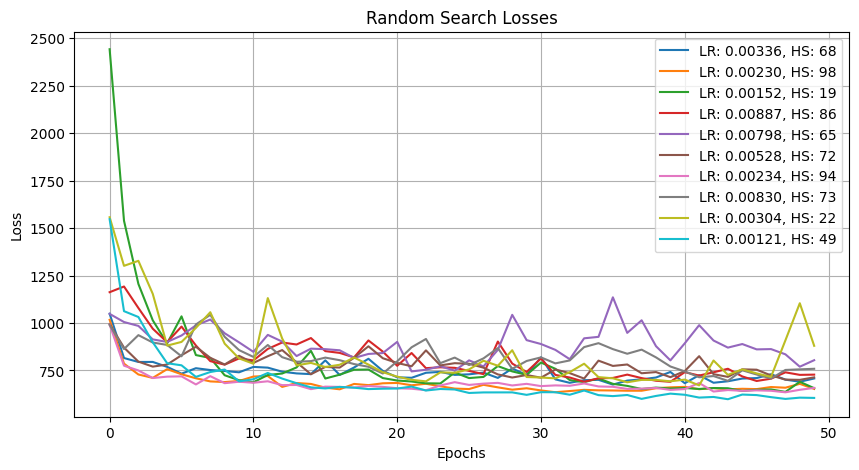

In [21]:
# Plot results for random search
plt.figure(figsize=(10, 5))
for result in random_results:
    plt.plot(result['losses'], label=f"LR: {result['learning_rate']:.5f}, HS: {result['hidden_layer_size']}")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Random Search Losses')
plt.legend()
plt.grid(True)
plt.show()

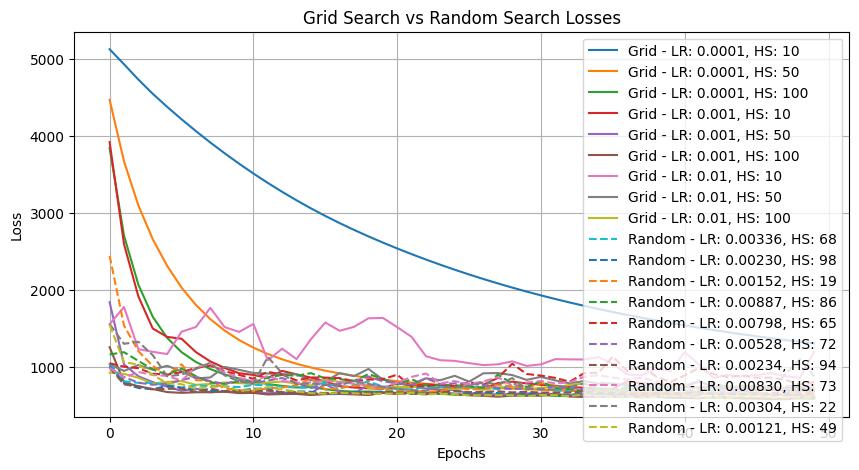

In [22]:
# Compare grid and random search
plt.figure(figsize=(10, 5))
for result in grid_results:
    plt.plot(result['losses'], label=f"Grid - LR: {result['learning_rate']}, HS: {result['hidden_layer_size']}")
for result in random_results:
    plt.plot(result['losses'], linestyle='dashed', label=f"Random - LR: {result['learning_rate']:.5f}, HS: {result['hidden_layer_size']}")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Grid Search vs Random Search Losses')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Find the best parameters from grid and random search
def find_best_result(results):
    best_result = min(results, key=lambda x: x['losses'][-1])  # Find result with the lowest final loss
    return best_result

In [25]:
best_grid_result = find_best_result(grid_results)
best_random_result = find_best_result(random_results)

In [26]:
# Display best results
print("\nBest Grid Search Result:")
print(f"Learning Rate: {best_grid_result['learning_rate']}")
print(f"Hidden Layer Size: {best_grid_result['hidden_layer_size']}")
print(f"Final Loss: {best_grid_result['losses'][-1]}")
print(f"Execution Time: {best_grid_result['execution_time']} seconds")


Best Grid Search Result:
Learning Rate: 0.0001
Hidden Layer Size: 100
Final Loss: 588.4043737770826
Execution Time: 231.24495840072632 seconds


In [27]:
print("\nBest Random Search Result:")
print(f"Learning Rate: {best_random_result['learning_rate']:.5f}")
print(f"Hidden Layer Size: {best_random_result['hidden_layer_size']}")
print(f"Final Loss: {best_random_result['losses'][-1]}")
print(f"Execution Time: {best_random_result['execution_time']} seconds")


Best Random Search Result:
Learning Rate: 0.00121
Hidden Layer Size: 49
Final Loss: 605.48364516907
Execution Time: 192.4098618030548 seconds
